# Heterogeneity in Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import yaml

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    return df

def read_dir(directory, csv_name, columns=None):
    dataframes = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            dataframes.append(read_file(os.path.join(directory, file), csv_name, columns))
    return pandas.concat(dataframes)

hpl_result_notrace = read_dir('heterogeneity_exp/', 'results.csv')
hpl_summary_notrace = hpl_result_notrace.groupby('node').mean().reset_index()
hpl_result_trace = read_dir('heterogeneity_exp/traces/', 'results.csv')
hpl_summary_trace = hpl_result_trace.groupby('node').mean().reset_index()
hpl_result = hpl_summary_notrace.set_index('node').join(hpl_summary_trace.set_index('node'), rsuffix='_trace').reset_index()
hpl_result.head()

,node,bcast,block_size,depth,gflops,index,matrix_size,mem_align,pfact,proc_p,...,mem_align_trace,pfact_trace,proc_p_trace,proc_q_trace,process_per_node_trace,residual_trace,rfact_trace,swap_trace,thread_per_process_trace,time_trace
0,1,2.0,128.0,1.0,805.20,4.5,65536.0,8.0,1.0,4.0,...,8,1,4,8,32,0.001254,2,0,1,232.386667
1,2,2.0,128.0,1.0,817.20,4.5,65536.0,8.0,1.0,4.0,...,8,1,4,8,32,0.001254,2,0,1,228.370000
2,3,2.0,128.0,1.0,827.16,4.5,65536.0,8.0,1.0,4.0,...,8,1,4,8,32,0.001254,2,0,1,225.533333
3,4,2.0,128.0,1.0,853.30,4.5,65536.0,8.0,1.0,4.0,...,8,1,4,8,32,0.001254,2,0,1,218.640000
4,5,2.0,128.0,1.0,827.48,4.5,65536.0,8.0,1.0,4.0,...,8,1,4,8,32,0.001254,2,0,1,230.353333


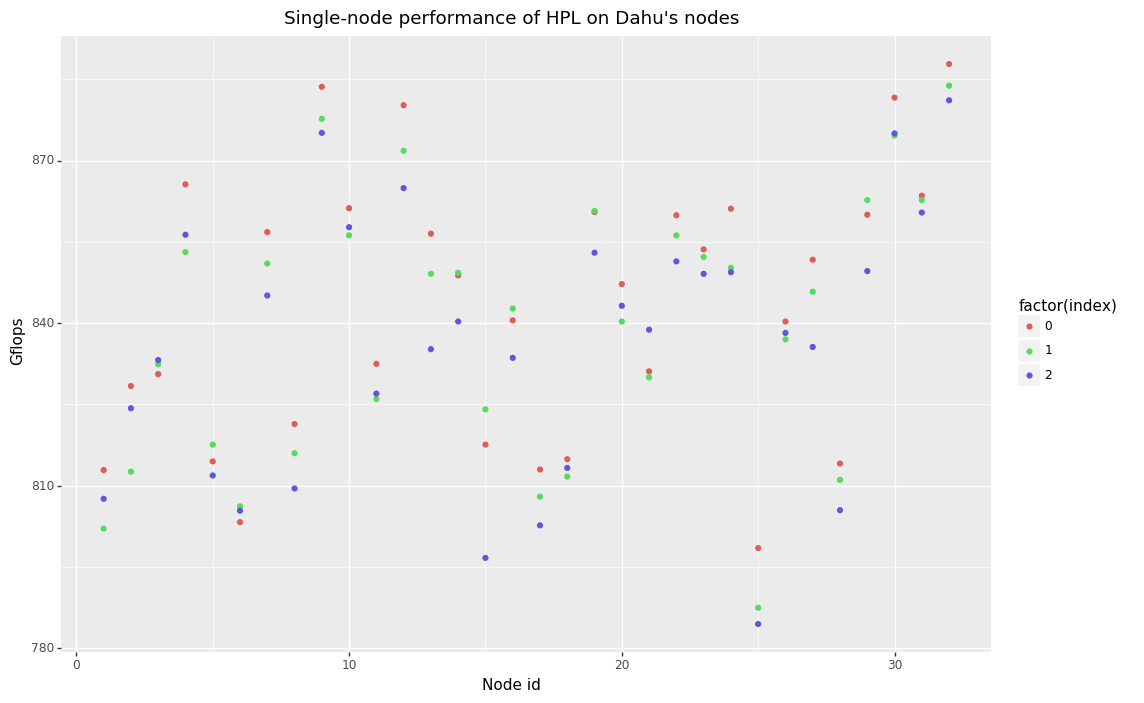

<ggplot: (-9223363274203755846)>

In [3]:
ggplot(hpl_result_trace, aes(x='node', y='gflops', color='factor(index)')) + geom_point() + ggtitle("Single-node performance of HPL on Dahu's nodes") + ylab('Gflops') + xlab('Node id')

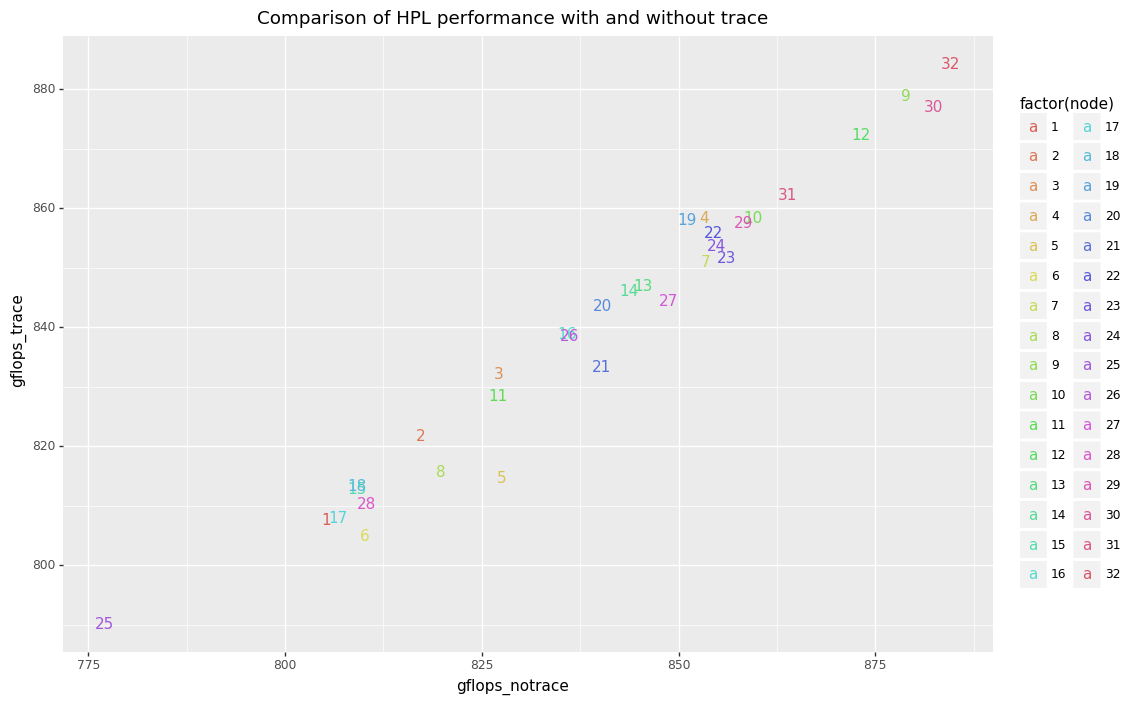

<ggplot: (8762648780808)>

In [4]:
ggplot(hpl_result, aes(x='gflops', y='gflops_trace', color='factor(node)')) + geom_text(aes(label='node')) + xlab('gflops_notrace') +\
    ggtitle('Comparison of HPL performance with and without trace')

In [5]:
foo = zipfile.ZipFile('heterogeneity_exp/traces/grenoble_2018-10-05_1811311.zip')
a=foo.filelist[0]
a.filename

'trace_0.paje'

In [6]:
def read_traces(archive_name, csv_name_start, columns=None, drop_duration_below=-1):
    alldf = []
    exp = 0
    for f in zipfile.ZipFile(archive_name).filelist:
        if f.filename.startswith(csv_name_start):
            df = read_file(archive_name, f.filename, columns)
            df = df[df.duration > drop_duration_below]
            df['exp_id'] = exp
            exp += 1
            alldf.append(df)
    return pandas.concat(alldf)
    
def read_traces_dir(directory, csv_name_start, columns=None, drop_duration_below=-1):
    dataframes = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            dataframes.append(read_traces(os.path.join(directory, file), csv_name_start, columns, drop_duration_below=drop_duration_below))
    return pandas.concat(dataframes)

In [7]:
%time hpl_blas = read_traces_dir('heterogeneity_exp/traces/', 'trace_blas', drop_duration_below=1e-4)
print(len(hpl_blas))
hpl_blas.head()

CPU times: user 2min 39s, sys: 22.4 s, total: 3min 1s
Wall time: 3min 1s
15691631


,function,file,line,rank,m,n,k,lead_A,lead_B,lead_C,duration,timestamp,node,index,exp_id
5,dgemm,../HPL_pdrpanrlT.c,224,0,16380,4,4,16392,128,16392,0.000129,0.000214,26,5,0
13,dgemm,../HPL_pdrpanrlT.c,224,0,16376,8,8,16392,128,16392,0.000278,0.000606,26,13,0
19,dgemm,../HPL_pdrpanrlT.c,224,0,16372,4,4,16392,128,16392,0.000117,0.001174,26,19,0
29,dgemm,../HPL_pdrpanrlT.c,224,0,16368,16,16,16392,128,16392,0.000730,0.001533,26,29,0
35,dgemm,../HPL_pdrpanrlT.c,224,0,16364,4,4,16392,128,16392,0.000119,0.002547,26,35,0


In [8]:
%%time
hpl_blas.m = hpl_blas.m.astype(float)
hpl_blas.n = hpl_blas.n.astype(float)
hpl_blas.k = hpl_blas.k.astype(float)
hpl_blas['mnk'] = hpl_blas.m * hpl_blas.n * hpl_blas.k
hpl_blas['mn2'] = hpl_blas.m * hpl_blas.n**2

CPU times: user 511 ms, sys: 582 ms, total: 1.09 s
Wall time: 1.09 s


In [9]:
%%time

import statsmodels.formula.api as sm

functions = {'dgemm': 'mnk', 'dtrsm': 'mn2'}
regressions = []
for node in hpl_blas.node.unique():
    for func, model in functions.items():
        reg = sm.ols(data=hpl_blas[(hpl_blas.node == node) & (hpl_blas.function == func)], formula='duration ~ %s' % model).fit()
        regressions.append({
            'node': node,
            'function': func,
            'intercept': reg.params['Intercept'],
            'coefficient': reg.params[model],
        })

regressions = pandas.DataFrame(regressions)

CPU times: user 58.8 s, sys: 33.7 s, total: 1min 32s
Wall time: 50.5 s


## Graphical representation of the coefficients

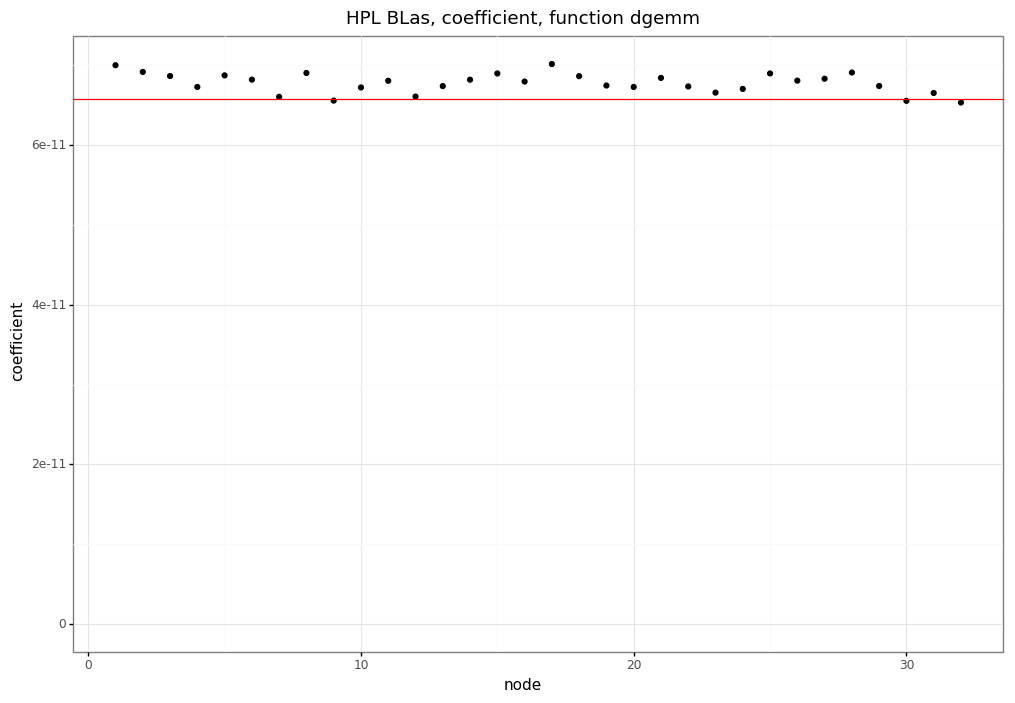

<ggplot: (8762648719613)>


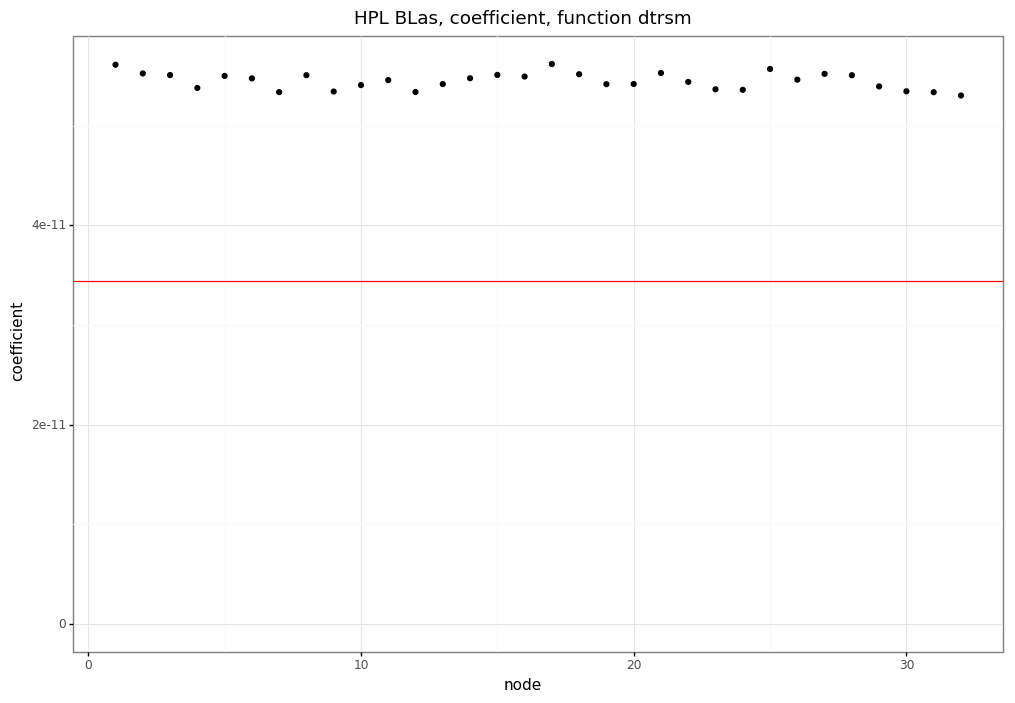

<ggplot: (8762648686589)>


In [10]:
coefficients = {
    'dgemm': 6.576115e-11,
    'dtrsm': 3.441913e-11,
}

def plot(df, y, line=True):
    for func in df.function.unique():
        plot = ggplot(df[df.function == func], aes(x='node', y=y)) + theme_bw()
        plot = plot + geom_point() + expand_limits(y=0) + ggtitle(func) + ggtitle('HPL BLas, %s, function %s' % (y, func))
        if line:
            plot += geom_hline(yintercept=coefficients[func], color='red')
        print(plot)

plot(regressions, 'coefficient')

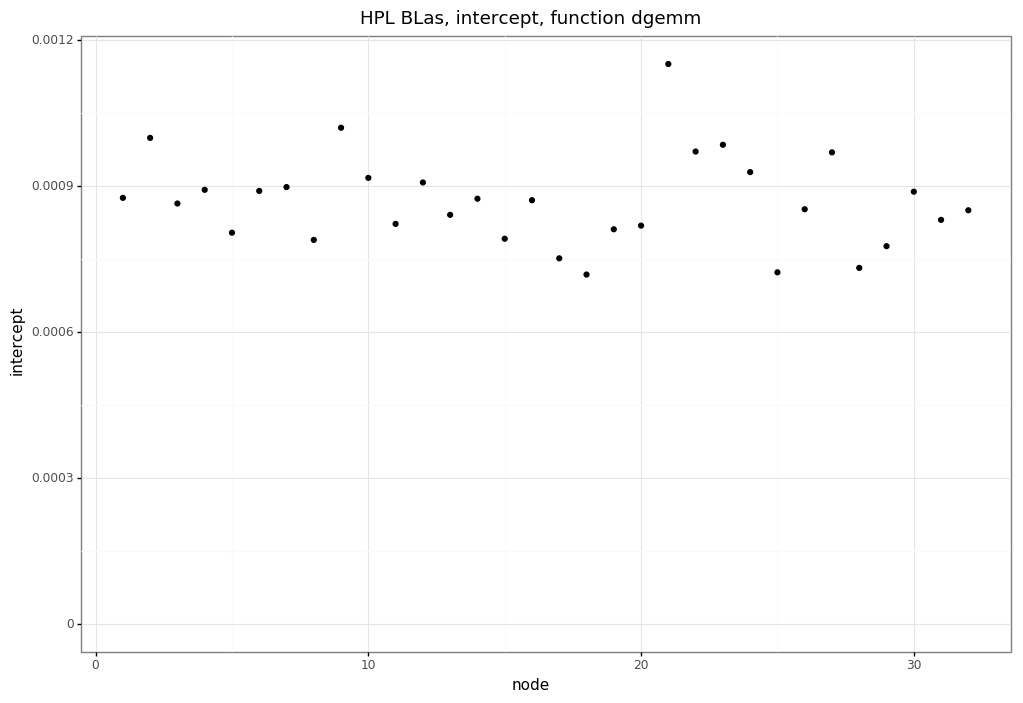

<ggplot: (-9223363274206040583)>


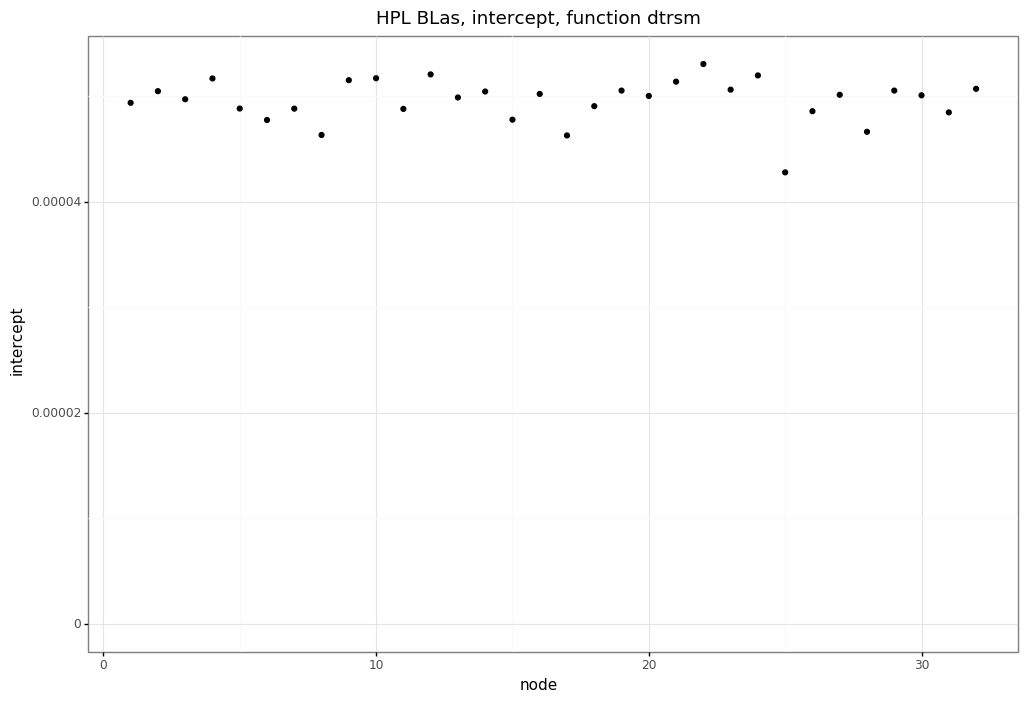

<ggplot: (8762648665597)>


In [11]:
plot(regressions, 'intercept', line=False)

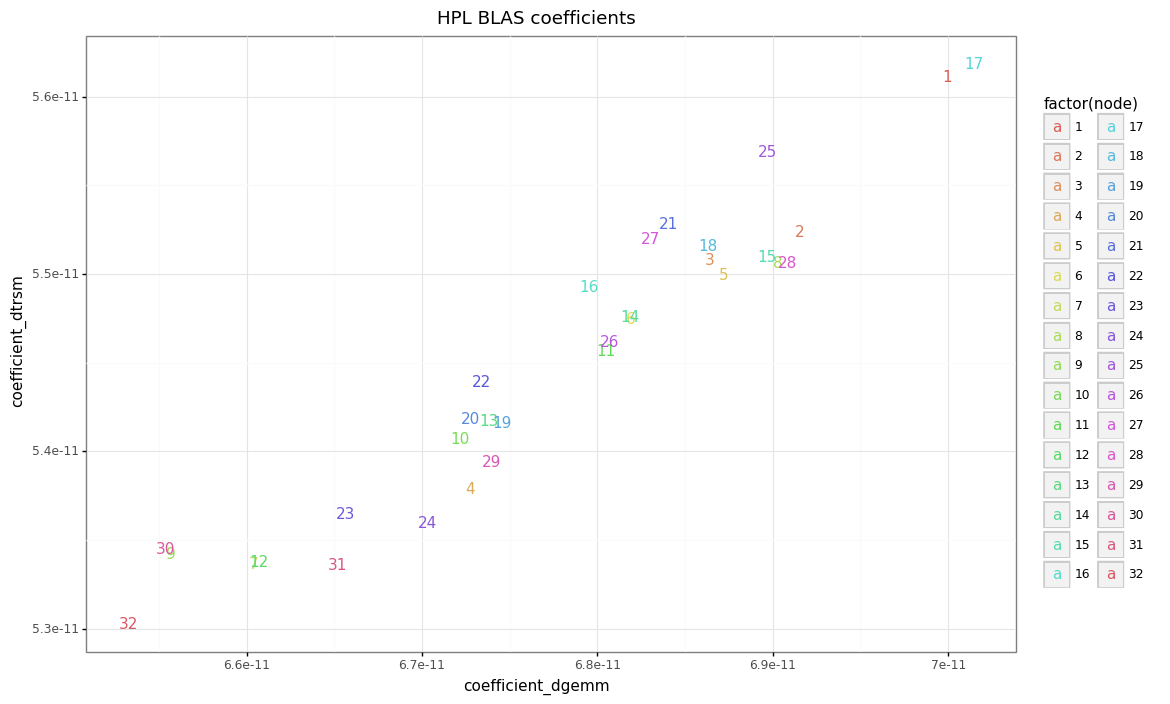

<ggplot: (-9223363274206099175)>

In [12]:
def plot_dgemm_vs_dtrsm(df):
    tmp_dgemm = df[df.function == 'dgemm']
    tmp_dtrsm = df[df.function == 'dtrsm']
    df = tmp_dgemm.set_index('node').join(tmp_dtrsm.set_index('node'), rsuffix='_dtrsm').reset_index()
    plot = ggplot(df, aes(x='coefficient', y='coefficient_dtrsm', color='factor(node)')) + theme_bw() + xlab('coefficient_dgemm')
    plot += geom_text(aes(label='node'))
    return plot

plot_dgemm_vs_dtrsm(regressions) + ggtitle('HPL BLAS coefficients')

## BLAS coefficients vs HPL performance

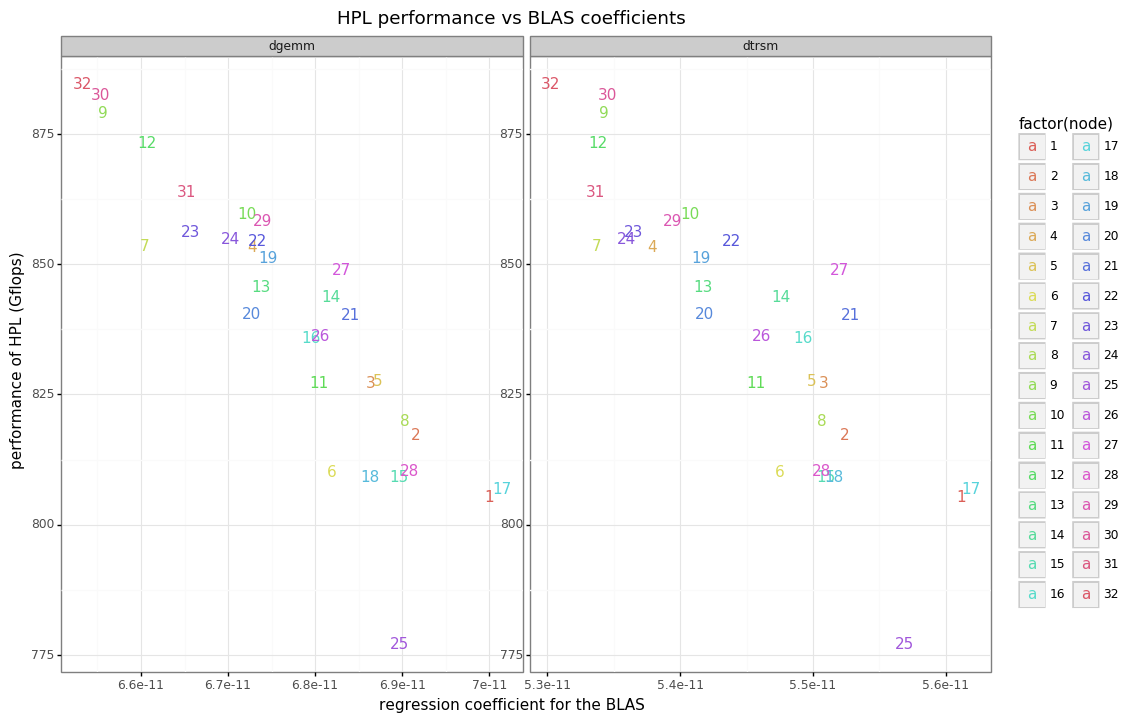

<ggplot: (8762648537327)>

In [13]:
def plot_blas_vs_hpl(df_blas, df_hpl, function='dgemm'):
    tmp_blas = df_blas
    tmp_hpl = df_hpl.groupby('node').mean().reset_index()
    df = tmp_blas.set_index('node').join(tmp_hpl.set_index('node'), rsuffix='_hpl').reset_index()
    plot = ggplot(df, aes(x='coefficient', y='gflops', color='factor(node)')) + theme_bw() + facet_wrap('function', scales='free')
    plot = plot + geom_text(aes(label='node')) + xlab('regression coefficient for the BLAS') + ylab('performance of HPL (Gflops)')
    return plot

plot_blas_vs_hpl(regressions, hpl_result) + ggtitle('HPL performance vs BLAS coefficients')

## Comparison with the BLAS calibration

In [14]:
columns = ['function', 'size', 'timestamp', 'time']

dir_blas_calibration = '../blas/heterogeneity_exp/'
df_multicore = read_dir(dir_blas_calibration, 'result_multicore.csv', columns)
df_monocore = read_dir(dir_blas_calibration, 'result_monocore.csv', columns)
df_monocore_contention = read_dir(dir_blas_calibration, 'result_monocore_contention.csv', columns)

In [15]:
def compute_reg(df_calibration):
    df_calibration['size_cube'] = df_calibration['size'].astype(float) ** 3
    blas_reg = []
    for node in df_calibration.node.unique():
        for func in df_calibration.function.unique():
            reg = sm.ols(data=df_calibration[(df_calibration.node == node) & (df_calibration.function == func)], formula='time ~ size_cube').fit()
            blas_reg.append({
                'node': node,
                'function': func,
                'intercept': reg.params['Intercept'],
                'coefficient': reg.params['size_cube'],
            })
    return pandas.DataFrame(blas_reg)

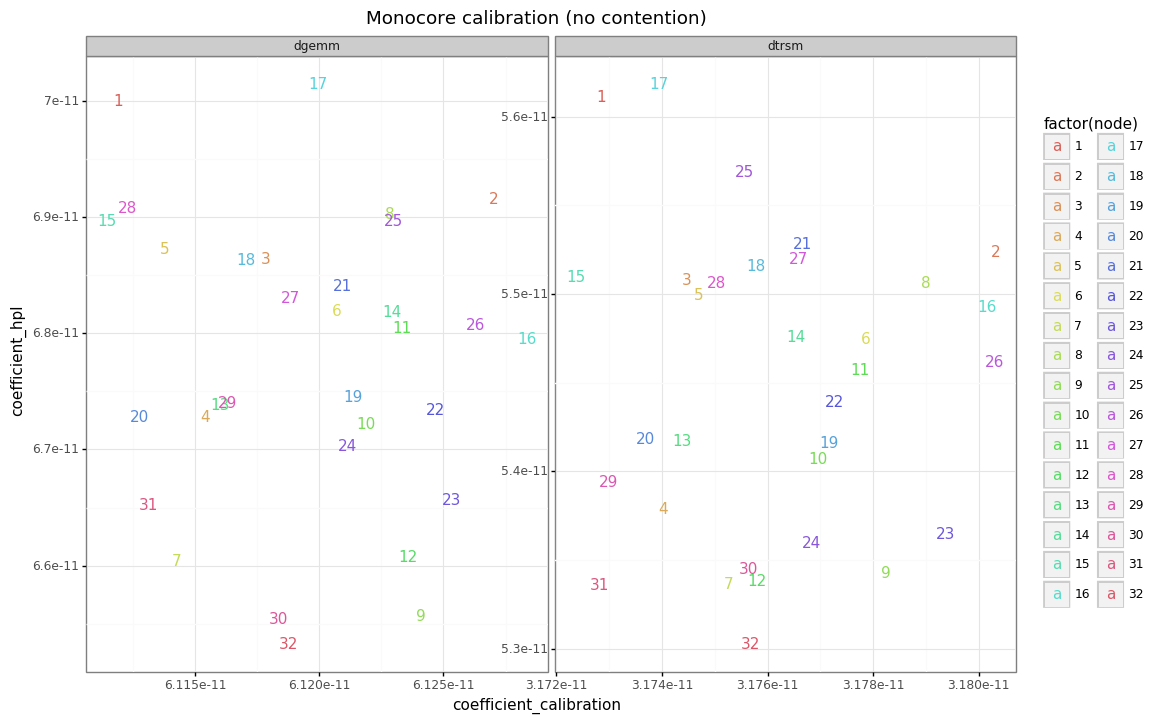

<ggplot: (-9223363274206372078)>

In [16]:
def plot_coefficients(calibration_reg, hpl_reg, calibration_factor=1):
    calibration_reg = calibration_reg.copy()
    calibration_reg.coefficient *= calibration_factor
    df = calibration_reg.set_index(['node', 'function']).join(hpl_reg.set_index(['node', 'function']), rsuffix='_hpl').reset_index()
    plot = ggplot(df, aes(x='coefficient', y='coefficient_hpl', color='factor(node)')) + geom_text(aes(label='node'))
    plot = plot + theme_bw() + xlab('coefficient_calibration') + facet_wrap('function', scales='free')
    return plot

plot_coefficients(compute_reg(df_monocore), regressions) + ggtitle('Monocore calibration (no contention)')

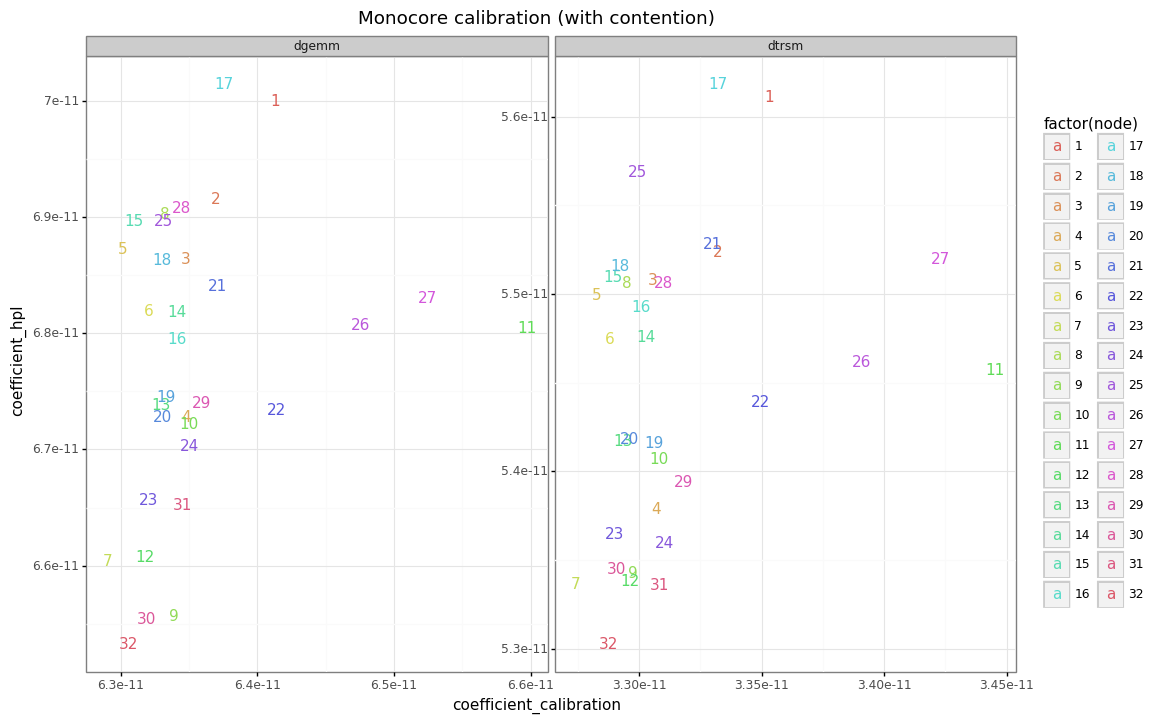

<ggplot: (-9223363274206154699)>

In [17]:
plot_coefficients(compute_reg(df_monocore_contention), regressions) + ggtitle('Monocore calibration (with contention)')

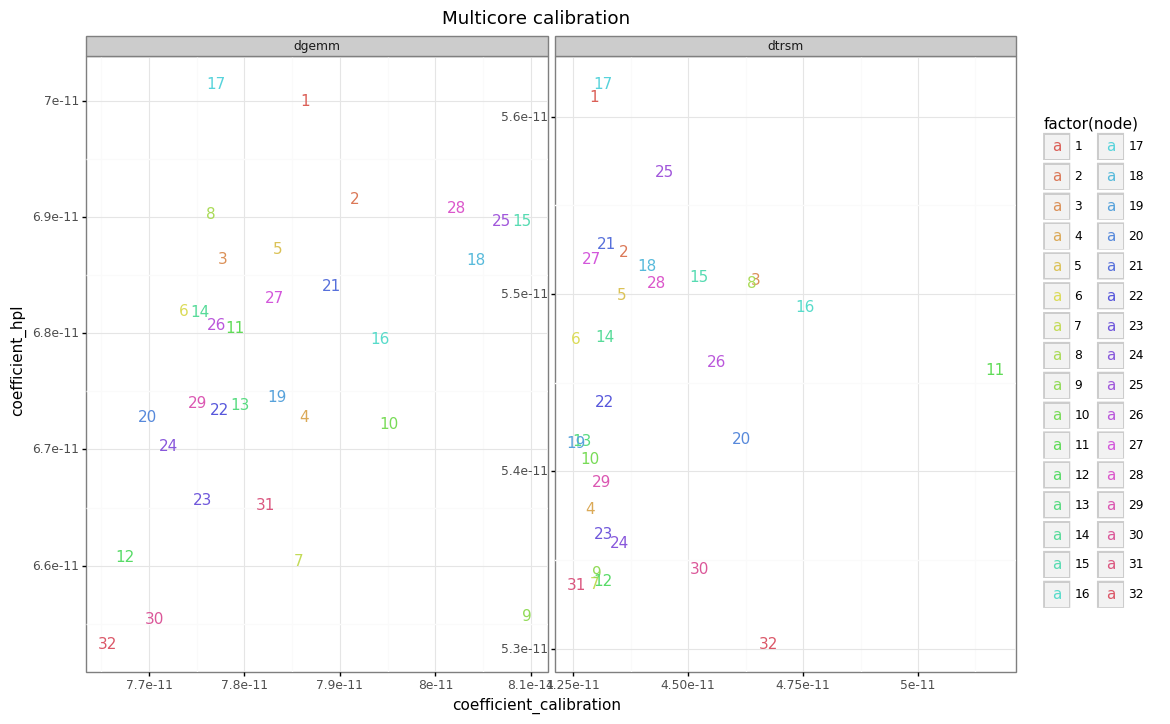

<ggplot: (8762648476680)>

In [18]:
plot_coefficients(compute_reg(df_multicore), regressions, calibration_factor=32) + ggtitle('Multicore calibration')

In [19]:
regressions[['function', 'coefficient', 'intercept']].groupby('function').describe()

coefficient                                                          \
               count          mean           std           min           25%   
function                                                                       
dgemm           32.0  6.776502e-11  1.256820e-12  6.532733e-11  6.716847e-11   
dtrsm           32.0  5.449172e-11  8.421704e-13  5.302720e-11  5.375197e-11   

                                                   intercept            \
                   50%           75%           max     count      mean   
function                                                                 
dgemm     6.800026e-11  6.866044e-11  7.014772e-11      32.0  0.000869   
dtrsm     5.459276e-11  5.508189e-11  5.618608e-11      32.0  0.000050   

                                                                      
               std       min       25%       50%       75%       max  
function                                                              
dgemm     0.000094  0.000718  0.000810  0.000868  0.000910  0.001151  
dtrsm     0.000002  0.000043  0.000049  0.000050  0.000051  0.000053